## Data

In [18]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.init as  init
import random


In [19]:
def load_months(X, stock):
    data = yf.download(stock, start='2010-01-01', end='2023-12-31', interval='1d')
    m = 1000
    for yr in data.index.year.unique():
        for mth in data.index.month.unique():
            if mth == 12:
                if yr == 2023:
                    continue
                d = data[(data.index.year == yr) & (data.index.month == mth) | (data.index.year == yr +1 ) & (data.index.month == 1)].Close.values
            else : 
                d = data[(data.index.year == yr) & (data.index.month.isin([mth, mth%12 + 1])) ].Close.values
            if len(d) < 38:
                continue
            X.append(d[:38])

In [20]:
normalized = True
X = []
if normalized == False:    
    tickers = stocks = [
    "AAPL", "GOOGL", "MSFT", "AMZN", "TSLA", "V", "JNJ", "WMT", "PG", "UNH", "MA", "NVDA", "HD", "BAC", "DIS", "VZ", "PYPL", "CMCSA",
    "ADBE", "NFLX", "INTC", "T", "PFE", "KO", "MRK", "PEP", "NKE", "ABT", "CRM", "XOM", "ACN", "ORCL", "CSCO", "ABBV", "TMO", "AVGO", "QCOM", "COST",
    "LLY", "MCD", "MDT", "DHR", "HON", "WFC", "UPS", "LIN", "BMY", "BA", "UNP", "TXN", "NEE", "LOW", "SAP", "IBM", "AMGN", "SBUX", "GE", "RTX",
    "CAT", "CVX", "GS", "MMM", "C", "LMT", "FIS", "MS", "BLK", "TGT", "DE", "SCHW", "ISRG", "NOW", "MO", "MDLZ", "MU", "PNC", "NSC", "INTU",
    "DXCM", "SYK", "GILD", "TJX", "ADP", "CI", "F", "GM", "AMAT", "CSX", "BKNG", "CL", "SPGI", "BDX", "ZTS", "REGN", "ATVI", "VRTX", "USB"
]
    for ticker in tickers:
        load_months(X, ticker)

    X = np.array(X)
    random.shuffle(X)

else:
    data = pd.read_csv('sliced_data.csv')
    Xordered = data.values
    np.array(Xordered)
    indices = np.arange(Xordered.shape[0])
    np.random.shuffle(indices)

    X = Xordered[indices]


In [21]:
train_X= torch.from_numpy(X[:int(len(X)*0.7)]).float()
test_X= torch.from_numpy(X[int(len(X)*0.7):]).float()

train_loader = DataLoader(train_X, batch_size=8, shuffle=True)
test_loader = DataLoader(test_X, batch_size=8, shuffle=True)


## VAE Model

In [22]:
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(4),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv1d(4, 8, kernel_size=3, padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv1d(8, 12, kernel_size=3, padding=1),
            nn.BatchNorm1d(12),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv1d(12, 16, kernel_size=3, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.4),
        )

        self.init_weights(self.encoder)

        self.fc_flatten = nn.Linear(60 * 16, 960)
        # map to latent z
        self.fc11 = nn.Linear(960, 10)
        self.fc12 = nn.Linear(960, 10)

        # decoder
        self.fc2 = nn.Linear(10, 960)
        self.fc_unflatten = nn.Linear(960, 60 * 16)
        
        self.init_weights(self.fc_flatten)
        self.init_weights(self.fc11)
        self.init_weights(self.fc12)
        self.init_weights(self.fc2)
        self.init_weights(self.fc_unflatten)



        self.decoder = nn.Sequential(
            nn.Conv1d(16, 12, kernel_size=3, padding=1),
            nn.BatchNorm1d(12),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv1d(12, 8, kernel_size=3, padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv1d(8, 4, kernel_size=3, padding=1),
            nn.BatchNorm1d(4),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv1d(4, 1, kernel_size=3, padding=1),
            nn.Dropout(0.4),
            nn.Sigmoid(),
        )
        self.init_weights(self.decoder)
    def encode(self, x):
        h = self.encoder(x)
        h_flat = h.view(h.size(0), -1)
        h_transformed = self.fc_flatten(h_flat)
        return self.fc11(h_transformed), self.fc12(h_transformed)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = self.fc_unflatten(self.fc2(z))
        z_unflat = z.view(-1, 16, 60)
        img = self.decoder(z_unflat)
        return img

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def init_weights(self, module):
        for m in module.modules():
            if isinstance(m, (nn.Linear, nn.Conv1d, nn.ConvTranspose1d)):
                init.uniform_(m.weight, 0.001, 0.01)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
  
def loss_function(recon_x, x, mu, logvar,k_recons=1,k_kl=0.1):
    
    BCE = nn.BCELoss()(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return k_recons*BCE + k_kl*KLD

## Training

In [23]:
k_recons = 1
k_kl = 0.1

In [24]:
# device to train our network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)

# optimizer chosen
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)


def train(start_epochs=1, n_epochs=2, test_loss_min_input=np.Inf, train_loader = train_loader, test_loader = test_loader, model=model, optimizer=optimizer):
    test_loss_list = []
    train_loss_list = []
    # initialize tracker for minimum validation loss
    test_loss_min = test_loss_min_input 
    
    for epoch in range(start_epochs, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        test_loss = 0.0
        
        ###################
        # train the model #
        ###################

        model.train()
        for batch_idx, data in enumerate(train_loader):
            # move to GPU if we can
            data = data.unsqueeze_(1).to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            recon_batch, mu, logvar = model(data)
            # calculate the batch loss
            loss = loss_function(recon_batch, data, mu, logvar,k_recons,k_kl)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a parameter update
            optimizer.step()
            # add the training loss
            train_loss += loss.item()
            # print the loss and the progression once log_interval reached
        
        scheduler.step()
        ######################    
        # validate the model #
        ######################
        
        model.eval()
        for _ , data in enumerate(test_loader):
            # move to GPU
            data = data.unsqueeze(1).to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            recon_batch, mu, logvar = model(data)
            # calculate the batch loss
            loss = loss_function(recon_batch, data, mu, logvar,k_recons,k_kl)
            # update average test loss 
            test_loss += loss.item()
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tTest Loss: {:.6f}'.format(
            epoch, 
            train_loss/len(train_loader.sampler),
            test_loss/len(test_loader.sampler)
            ))
        train_loss_list.append(train_loss/len(train_loader.sampler))
        test_loss_list.append(test_loss/len(test_loader.sampler))

        # save the model if test loss has decreased
        if test_loss <= test_loss_min:
            print('Test loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(test_loss_min,test_loss))
            # save checkpoint as best model
            test_loss_min = test_loss
            torch.save(model.state_dict(),"VAEConvModel.pth")
        
    plt.plot(train_loss_list[3:], label='train')
    plt.plot(test_loss_list[3:], label='test')
    plt.legend()
    plt.show()

In [25]:
train(n_epochs=50)

Epoch: 1 	Training Loss: 11906229297242688402227200.000000 	Test Loss: 1576.562276
Test loss decreased (inf --> 1802010.681587).  Saving model ...
Epoch: 2 	Training Loss: 43207914.873350 	Test Loss: 217.967482
Test loss decreased (1802010.681587 --> 249136.832403).  Saving model ...
Epoch: 3 	Training Loss: 2313.404554 	Test Loss: 60.358917
Test loss decreased (249136.832403 --> 68990.242306).  Saving model ...
Epoch: 4 	Training Loss: 21.344758 	Test Loss: 40.157661
Test loss decreased (68990.242306 --> 45900.206601).  Saving model ...
Epoch: 5 	Training Loss: 56353006209840.687500 	Test Loss: 47.965565
Epoch: 6 	Training Loss: 148.317896 	Test Loss: 56.703759
Epoch: 7 	Training Loss: 36.508337 	Test Loss: 39.727039
Test loss decreased (45900.206601 --> 45408.005028).  Saving model ...
Epoch: 8 	Training Loss: 36.892160 	Test Loss: 50.296682
Epoch: 9 	Training Loss: 36.660546 	Test Loss: 70.245854
Epoch: 10 	Training Loss: 33.143235 	Test Loss: 68.744277
Epoch: 11 	Training Loss: 33.

KeyboardInterrupt: 

## Generate

In [26]:
vae_model = VAE()
vae_model.load_state_dict(torch.load('VAEConvModel.pth'))
vae_model.eval()

# Définir le nombre de données à générer
nombre_de_donnees = 10

# Échantillonner à partir de la distribution latente
with torch.no_grad():
    z = torch.randn(nombre_de_donnees,10)
    display(z)

# Décoder les échantillons
donnees_generees = vae_model.decode(z)

tensor([[ 2.1102, -1.3820, -0.7544, -0.2821, -0.9160,  0.5179,  0.3279, -0.4062,
         -0.8340, -0.0409],
        [-0.8073, -0.9069, -1.3899,  1.0092, -1.7672, -0.0837, -1.9142,  0.2748,
          0.7333, -0.8882],
        [ 1.0086, -0.0577, -0.4435, -0.7905, -0.1048, -0.4805,  0.3277, -0.3391,
         -1.9507, -0.1901],
        [ 0.1099, -1.8633, -1.3096,  0.6633, -0.0682, -0.9516,  0.0833, -0.0656,
         -0.5727, -0.8519],
        [ 0.8091, -1.8393,  0.8620,  2.6917,  1.6913,  0.2403, -0.2870,  0.0561,
         -1.2489,  0.5438],
        [ 0.9636,  0.1325,  0.8472,  0.1392, -0.8122,  0.0817,  0.3001,  0.5285,
         -0.8257,  0.5695],
        [ 2.3294, -0.8616, -1.2435, -1.8720,  0.3494, -0.1310, -0.2917, -1.4534,
          0.4893, -0.6085],
        [-1.1549, -0.8222,  0.5646, -0.2587, -0.3352, -0.8790,  0.6346,  0.1845,
         -2.1056, -1.4592],
        [-0.1414, -0.5196, -0.1895, -1.3091,  0.0851,  0.5366, -0.5248,  0.0164,
         -0.4957, -0.0283],
        [-0.7035, -

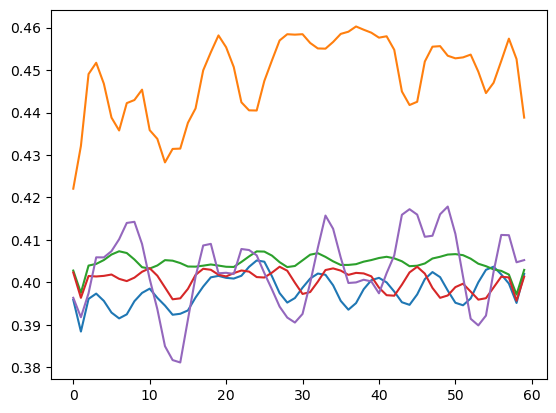

In [27]:
for serie in donnees_generees.squeeze(1)[:5]:
    plt.plot(serie.detach().numpy())

plt.show()

## PCA on generated data

In [29]:
from sklearn.decomposition import PCA
sliced = pd.read_csv("sliced_data.csv")
pca = PCA(n_components=2)
pca.fit(sliced)
gen_pca = pca.transform(donnees_generees.squeeze(1).detach().numpy())

/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


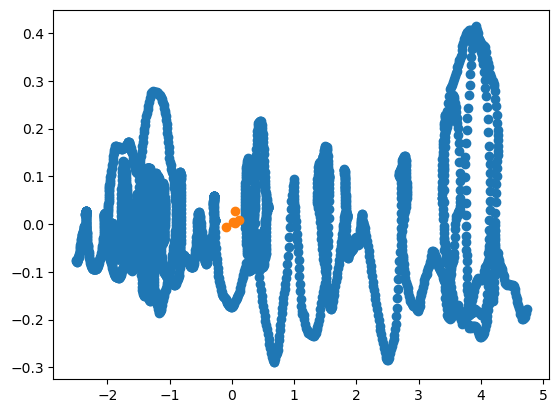

In [28]:
right_pca = pd.read_csv("sliced_data_pca.csv")
plt.scatter(right_pca.iloc[:,0].values, right_pca.iloc[:,1].values)
plt.scatter(gen_pca[:,0], gen_pca[:,1])
